# Setup
This section identifies the package installs and imports needed for the notebook


## Installs

## Graphviz
Install from windows msi - https://graphviz.gitlab.io/_pages/Download/Download_windows.html
Restart the kernel to be sure
Update PATH environment variable for path to bin directory

Install is buggy, so might need to set path at runtime:
import os 
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

## Pydot

In [1]:
# https://pypi.org/project/pydot/

!pip install pydot

## Pandas Profiling

In [2]:
# https://pypi.org/project/pandas-profiling/

!pip install pandas_profiling

## Imports and Settings

In [3]:
import os
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
import pandas_profiling as pp

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus
import collections
from sklearn import preprocessing

In [4]:
from demyst.analytics import Analytics
from demyst.analytics.report import report


## Set flag to use cached enrichment data or to fetch anew thru API
Set to True to use cached data, False to redo enrichment steps from the API


In [5]:
use_cached_data = True

In [6]:
# Input / output data files are available in the "./data" directory

print(os.listdir("./data"))

['9550.csv', '9552.csv', '9555.csv', '9557.csv', '9559.csv', '9569.csv', '9570.csv', '9571.csv', '9573.csv', '9576.csv', '9579.csv', '9584.csv', '9586.csv', '9587.csv', '9592.csv', '9593.csv', '9594.csv', 'full_inputs.csv', 'input_file1.csv', 'results_enrich1.csv', 'results_enrich2.csv', 'testdfforDecisionTree.csv']


# Load and Analyze Input Data Set 

## Load Source Data File

In [7]:
full_inputs = pd.read_csv('./data/input_file1.csv', encoding='UTF-8', dtype={'postcode': object})
full_inputs.head()

,street,state,city,postcode,safety_flag
0,3160 Otto Dr,FL,Lakeland,33812-5237,False
1,940 Tulip Dr,IN,Indianapolis,46227,False
2,68 Rocky Top Rd,VA,Troutville,24175-6054,False
3,3330 Taylor Blair Rd,OH,West Jefferson,43162,False
4,4254 Eagle Landing Parkway,FL,Orange Park,32065,False


## Review with Pandas Profiling

In [8]:
pp.ProfileReport(full_inputs)

## Start Demyst Analytics Analysis

In [9]:
#analytics = Analytics()
analytics = Analytics(username="hsingh+saleem@demystdata.com", password="-yh;5^qz(pCPy<EL")

In [10]:
analytics.validate(full_inputs)

Column,Status,Description
street,All Valid,All values in this column are good to go.
state,Some Invalid,16.8% of the values of this column failed validation. One example of an invalid value is 'NJ '. Click here for documentation for this column.
city,All Valid,All values in this column are good to go.
postcode,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.


## Look for potential enrichment providers and required keys

In [11]:
analytics.search(full_inputs, False)

,city,street,post_code,state,country
Option 1,☒,☒,☐,☒,☐


## Clean Up Input File

### Review .isna records

Identify and review records to be dropped by df.isna. Could enhance with address parser / validator to salvage these rows. Initially dropping these records.

In [12]:
#looking for na in State column
indx = full_inputs.index[full_inputs['state'].isna()]
#full_inputs.index[full_inputs['state'].isna()]
full_inputs.loc[indx]
print(indx.to_list())

[9347, 9388, 9694, 9790, 10528, 10531, 10634, 11129, 11219]


Check each column in the data set to find all rows with na's for review. 

A few additional records as shown below could be salvaged with address parsing / validation as a follow up.

In [13]:
col_names = full_inputs.columns.to_list()
#print(col_names)
na_recs = []
for col_name in col_names:
    x = full_inputs.index[full_inputs[col_name].isna()]
    na_recs.append(x.to_list())

flat_list = [item for sublist in na_recs for item in sublist]
na_recs_list = list(set(flat_list))
print('dropna will remove {} records:'.format(len(na_recs_list)))
full_inputs.iloc[na_recs_list]

dropna will remove 10 records:


,street,state,city,postcode,safety_flag
10528,PO Box 390183 211 Hope Street,NaN,NaN,NaN,True
9347,,NaN,NaN,NaN,False
10531,,NaN,NaN,NaN,False
9694,,NaN,NaN,NaN,False
9860,"5805 Sepulveda Blvd, Ste 670",CA,Van Nuys,NaN,True
10634,200 Vesey St Suite 24081,NaN,NaN,NaN,False
9388,499 Beckett Road Suite 201B,NaN,NaN,NaN,True
11219,"3333 Michelson Dr Suite 300 Irvine, CA 92612",NaN,NaN,NaN,False
11129,"147 Prince Street Brooklyn, NY 11201",NaN,NaN,NaN,False
9790,3534 Berthat,NaN,NaN,11510,True


### Dropping the na records

In [14]:
print('Before dropna {}'.format( full_inputs.shape[0]))
full_inputs.dropna(inplace=True)
print('After dropna {}'.format( full_inputs.shape[0]))


Before dropna 11229
After dropna 11219


### Add country column since all records look to be in the US and country is required for enrichment.

In [15]:
full_inputs['country'] = 'US'

### Clean Up postcodes

In [16]:
# Simple function to clean up postal codes in the data set

def standardize_postcodes (postcode):
    l = len(postcode)
    
    if l==4:
        return postcode.zfill(5), ''
    elif l==5:
        return postcode, ''
    elif l==9:
        return postcode[0:5], postcode[5:9]
    elif l==10:
        return postcode[0:5], postcode[6:10]
    else:
        return '', ''

In [17]:
# Standardize post code formats and match Demyst naming convention for validation
full_inputs['post_code'], full_inputs['post_code_plus4'] = zip(*full_inputs['postcode'].map(standardize_postcodes))

### Standardize State column

In [18]:
full_inputs['state'].unique()

array(['FL', 'IN', 'VA', 'OH', 'MA', 'MN', 'WI', 'NC', 'CO', 'CA', 'NY',
       'NH', 'CT', 'MD', 'NJ', 'KY', 'WA', 'IA', 'LA', 'GA', 'IL', 'TX',
       'AZ', 'DE', 'MI', 'RI', 'OR', 'AR', 'HI', 'PA', 'SC', 'AL', 'TN',
       'WY', 'NV', 'NE', 'MT', 'MS', 'OK', 'KS', 'MO', 'ID', 'DC', 'UT',
       'NM', 'ND', 'ME', 'VT', 'AK', 'SD', 'NJ  ', 'NY  ', 'CA  ', 'OR  ',
       'GA  ', 'MI  ', 'AZ  ', 'TX  ', 'PA  '], dtype=object)

In [19]:
full_inputs['state'] = full_inputs.apply(lambda x: x['state'].strip(), axis=1)
print(full_inputs.state.unique())
print (full_inputs.state.unique().shape[0])


['FL' 'IN' 'VA' 'OH' 'MA' 'MN' 'WI' 'NC' 'CO' 'CA' 'NY' 'NH' 'CT' 'MD'
 'NJ' 'KY' 'WA' 'IA' 'LA' 'GA' 'IL' 'TX' 'AZ' 'DE' 'MI' 'RI' 'OR' 'AR'
 'HI' 'PA' 'SC' 'AL' 'TN' 'WY' 'NV' 'NE' 'MT' 'MS' 'OK' 'KS' 'MO' 'ID'
 'DC' 'UT' 'NM' 'ND' 'ME' 'VT' 'AK' 'SD']
50


## Re-run Demyst validate step to verify cleanup

In [20]:
analytics.validate(full_inputs)

Column,Status,Description
street,All Valid,All values in this column are good to go.
state,All Valid,All values in this column are good to go.
city,All Valid,All values in this column are good to go.
postcode,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.
country,All Valid,All values in this column are good to go.
post_code,All Valid,All values in this column are good to go.
post_code_plus4,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.


### Rerun Profiler on cleaned data set

In [21]:
pp.ProfileReport(full_inputs)

# Start Enrichment Processing
Take a subset for development and protyping or run the full set for enrichment


In [22]:
# Comment out appropriate line to either run sample or complete data set

#inputs = full_inputs[9000: 9065].copy()  # for small test runs
inputs = full_inputs  # for full run

In [23]:
analytics.search(inputs)

,city,street,post_code,state,country
Option 1,☒,☒,☒,☒,☒


## This section is included just for reference - a workaround to run enrichment in batches
Running the full input data set resulted in a corrupted download file with an encoding error, rendering it unusable.

In [24]:
"""
/*batchsize=25
products_list = ['attom_expanded_profile_report']
job_nums = []
for i in range(0, inputs.shape[0], batchsize):
        print ("Start ", i)
        #print(df[i: i+batchsize])
        job_num = analytics.enrich(products_list, inputs[i: i+batchsize])
        print ("Job ID: ", job_num)
        job_nums.append(job_num)
print("Batch run jobs: ", job_nums)
""" 

'\n/*batchsize=25\nproducts_list = [\'attom_expanded_profile_report\']\njob_nums = []\nfor i in range(0, inputs.shape[0], batchsize):\n        print ("Start ", i)\n        #print(df[i: i+batchsize])\n        job_num = analytics.enrich(products_list, inputs[i: i+batchsize])\n        print ("Job ID: ", job_num)\n        job_nums.append(job_num)\nprint("Batch run jobs: ", job_nums)\n'

### Batch Option - Check for batch jobs completion

In [25]:
"""
for job in job_nums:
    analytics.enrich_status(job)
"""

'\nfor job in job_nums:\n    analytics.enrich_status(job)\n'

### Batch Option - Download enriched data sets

In [26]:
"""
for job in job_nums:
    results = analytics.enrich_download(job)
    results.to_csv('./data/batch{}.csv'.format(job))
"""

"\nfor job in job_nums:\n    results = analytics.enrich_download(job)\n    results.to_csv('./data/batch{}.csv'.format(job))\n"

## End of Skip Section

## Enrichment - Step 1 - get Attom ID
Enrich input data with attom_id from the API or using the previously cached data provided with this notebook  

### Input and cached interim data files can be found in the ./data directory

In [27]:
print(os.listdir("./data"))

['9550.csv', '9552.csv', '9555.csv', '9557.csv', '9559.csv', '9569.csv', '9570.csv', '9571.csv', '9573.csv', '9576.csv', '9579.csv', '9584.csv', '9586.csv', '9587.csv', '9592.csv', '9593.csv', '9594.csv', 'full_inputs.csv', 'input_file1.csv', 'results_enrich1.csv', 'results_enrich2.csv', 'testdfforDecisionTree.csv']


In [28]:
file_name = './data/results_enrich1.csv'
    
if (use_cached_data):
    results = pd.read_csv(file_name)
    print ("Enriched results from cached data") 

else:
    results = analytics.enrich_and_download(['attom_expanded_profile_report'], inputs)
    results.to_csv(file_name)
    results = pd.read_csv(file_name)
    print ("Enriched results from API") 


Enriched results from cached data


In [29]:
print (results.shape)
results.head()

(500, 13)


,Unnamed: 0,inputs.city,inputs.country,inputs.post_code,inputs.post_code_plus4,inputs.postcode,inputs.safety_flag,inputs.state,inputs.street,attom_expanded_profile_report.row_id,attom_expanded_profile_report.client_id,attom_expanded_profile_report.attom_id,attom_expanded_profile_report.error
0,0,Fremont,US,68025,4417.0,68025-4417,False,NE,1924 E 12th St,0,NaN,NaN,NaN
1,1,Milwaukee,US,53220,2959.0,53220-2959,False,WI,7120 W Plainfield Ave,1,NaN,189032233.0,NaN
2,2,Franklinton,US,70438,NaN,70438,False,LA,51381 Turnage Stateline Road,2,NaN,NaN,NaN
3,3,Wilson,US,27893,4610.0,27893-4610,False,NC,1902 Downing St SW,3,NaN,NaN,NaN
4,4,Taylorsville,US,30178,NaN,30178,False,GA,11 Corson Trail,4,NaN,171081028.0,NaN


## Enrichment - Step2 - Fetch additional data providers based on attom_id


### Search for enrichment data sets


Prepare result data for additional Attom enrichment: (1) rename the attom_id column for the provider search and (2) drop records without attom_id's

In [30]:
results.rename(columns = {'attom_expanded_profile_report.attom_id': 'attom_id'}, inplace=True)

index_recs = results[ results['attom_id'].isna() ].index
results.drop(index_recs , inplace=True)

In [31]:
analytics.search(results)

Note: the cell below was for prototyping and searches & enriches by all possible providers, resulting in 1000+ columns. So, for this challenge, I'll be limiting to a single enrichment provider. Code left below for reference.

In [32]:
"""
# List full set of providers available by attom_id, for use in enrich_and_download step
attomid_providers = analytics.search(results, view="json")
prov_list = []
for prov in attomid_providers:
    prov_list.append(prov['name'])
    
print (prov_list)
results2 = analytics.enrich_and_download(prov_list, results)

# NOTE: After initial test run of the full range of available providers yielding > 1000 columns, limiting actual dataset going forward to just 'attom recorder'

"""

'\n# List full set of providers available by attom_id, for use in enrich_and_download step\nattomid_providers = analytics.search(results, view="json")\nprov_list = []\nfor prov in attomid_providers:\n    prov_list.append(prov[\'name\'])\n    \nprint (prov_list)\nresults2 = analytics.enrich_and_download(prov_list, results)\n\n# NOTE: After initial test run of the full range of available providers yielding > 1000 columns, limiting actual dataset going forward to just \'attom recorder\'\n\n'

### Enriching only by attom_recorder either from the API or from cached data file based on use_cached_data flag. 

#### NOTE: Using a cached data set from a prototyping run which only has 379 records and data from the Attom Recorder provider.


In [33]:
file_name = './data/results_enrich2.csv'

if (use_cached_data):
    results2 = pd.read_csv(file_name)
    print ("Using enriched results from cached data") 
    
else:
    results2 = analytics.enrich_and_download(['attom_recorder'], results)
    results2.to_csv(file_name)
    ####result2 = pd.load_csv(file_name)
    print ("Using enriched results from API") 



Using enriched results from cached data


In [34]:
#NOT NEEDED IF LOADING FROM CSV#print("Results2 shape before: ", results2.shape)
#df1 = results2.filter(like='inputs.', axis=1)
#df2 = results2.filter(like='attom_recorder.', axis=1)
#results2 = pd.concat([df1, df2], axis=1)
#print("Results2 shape after: ", results2.shape)
#df_all_cols = pd.concat([df1, df2], axis = 1)
#df.head()


In [35]:
results2.head()

,Unnamed: 0,inputs.attom_expanded_profile_report.client_id,inputs.attom_expanded_profile_report.error,inputs.attom_expanded_profile_report.row_id,inputs.attom_id,inputs.inputs.city,inputs.inputs.country,inputs.inputs.post_code,inputs.inputs.post_code_plus4,inputs.inputs.postcode,inputs.inputs.safety_flag,inputs.inputs.state,inputs.inputs.street,attom_recorder.row_id,attom_recorder.client_id,attom_recorder.apnformatted,attom_recorder.apnoriginal,attom_recorder.armslengthflag,attom_recorder.attom_id,attom_recorder.book,attom_recorder.documentnumberformatted,attom_recorder.documentnumberlegacy,attom_recorder.documentrecordingcountyfips,attom_recorder.documentrecordingcountyname,attom_recorder.documentrecordingjurisdictionname,attom_recorder.documentrecordingstatecode,attom_recorder.documenttypecode,attom_recorder.foreclosureauctionsale,attom_recorder.grantee1infoentityclassification,attom_recorder.grantee1infoownertype,attom_recorder.grantee1namefirst,attom_recorder.grantee1namefull,attom_recorder.grantee1namelast,attom_recorder.grantee1namemiddle,attom_recorder.grantee1namesuffix,attom_recorder.grantee2infoentityclassification,attom_recorder.grantee2namefirst,attom_recorder.grantee2namefull,attom_recorder.grantee2namelast,attom_recorder.grantee2namemiddle,attom_recorder.grantee2namesuffix,attom_recorder.grantee3infoentityclassification,attom_recorder.grantee3namefirst,attom_recorder.grantee3namefull,attom_recorder.grantee3namelast,attom_recorder.grantee3namemiddle,attom_recorder.grantee3namesuffix,attom_recorder.grantee4infoentityclassification,attom_recorder.grantee4namefirst,attom_recorder.grantee4namefull,attom_recorder.grantee4namelast,attom_recorder.grantee4namemiddle,attom_recorder.grantee4namesuffix,attom_recorder.granteegrantorownerrelationshipcode,attom_recorder.granteeinfoentitycount,attom_recorder.granteeinfovesting1,attom_recorder.granteeinfovesting2,attom_recorder.granteeinvestorflag,attom_recorder.granteemailaddresscity,attom_recorder.granteemailaddresscrrt,attom_recorder.granteemailaddressfull,attom_recorder.granteemailaddresshousenumber,attom_recorder.granteemailaddressinfoformat,attom_recorder.granteemailaddressinfoprivacy,attom_recorder.granteemailaddressstate,attom_recorder.granteemailaddressstreetdirection,attom_recorder.granteemailaddressstreetname,attom_recorder.granteemailaddressstreetpostdirection,attom_recorder.granteemailaddressstreetsuffix,attom_recorder.granteemailaddressunitprefix,attom_recorder.granteemailaddressunitvalue,attom_recorder.granteemailaddresszip,attom_recorder.granteemailaddresszip4,attom_recorder.granteemailcareofname,attom_recorder.grantor1infoentityclassification,attom_recorder.grantor1infoownertype,attom_recorder.grantor1namefirst,attom_recorder.grantor1namefull,attom_recorder.grantor1namelast,attom_recorder.grantor1namemiddle,attom_recorder.grantor1namesuffix,attom_recorder.grantor2infoentityclassification,attom_recorder.grantor2infoownertype,attom_recorder.grantor2namefirst,attom_recorder.grantor2namefull,attom_recorder.grantor2namelast,attom_recorder.grantor2namemiddle,attom_recorder.grantor2namesuffix,attom_recorder.grantor3infoentityclassification,attom_recorder.grantor3namefirst,attom_recorder.grantor3namefull,attom_recorder.grantor3namelast,attom_recorder.grantor3namemiddle,attom_recorder.grantor3namesuffix,attom_recorder.grantor4infoentityclassification,attom_recorder.grantor4namefirst,attom_recorder.grantor4namefull,attom_recorder.grantor4namelast,attom_recorder.grantor4namemiddle,attom_recorder.grantor4namesuffix,attom_recorder.grantoraddresscity,attom_recorder.grantoraddresscrrt,attom_recorder.grantoraddressfull,attom_recorder.grantoraddresshousenumber,attom_recorder.grantoraddressinfoformat,attom_recorder.grantoraddressinfoprivacy,attom_recorder.grantoraddressstate,attom_recorder.grantoraddressstreetdirection,attom_recorder.grantoraddressstreetname,attom_recorder.grantoraddressstreetpostdirection,attom_recorder.grantoraddressstreetsuffix,attom_recorder.grantoraddressunit

## Feature Analysis / Selection - custom analysis to review and elimate certain features
The enirched data set is too wide for PP package to handle so this is some custom analysis to analyze the Results dataframe for unique values and missing values in each column for criteria to reduce to a more meaningful set of features.

Building a new dataframe containing the column names from the Results dataframe and some profiling stats  to help determine a good set of features to focus on in the subsequent modeling. Using a list of lists containing each column and the statistics.

In [36]:
total_recs = results2.shape[0]
cols_list = []

for col_name in results2.columns:
    tmp = [] 
    d_type = results2[col_name].dtype
    tmp.append (col_name)                       # the name of the column in the results datafram
    tmp.append(d_type)                          # the data type of that column
    tmp.append (results2[col_name].nunique())   # number of unique values in the column
    
    #Count of null/nan/empty string items in the column. This would be expanded to cover all DTypes in a more generalized solution, ignoring bool type of response variable
    if d_type == 'O': # Dtype is Object
        #tmp.append((results2[col_name].values == '').sum())
        tmp.append( results2[col_name].isna().sum() )
    elif d_type in ['int64', 'float64']:
        tmp.append( results2[col_name].isna().sum() )
    
    tmp.append(total_recs)    #total number of records in the dataframe
    cols_list.append(tmp)

#cols_list                 #uncomment this line to see the full listing of the core stats
    

### Build the column profiling dataframe from the list of lists

In [37]:
cols_list_df = pd.DataFrame(cols_list, columns=['Column', 'Dtype', 'NumUnique', 'NumNa', 'TotalRecCt'])
cols_list_df.head()

,Column,Dtype,NumUnique,NumNa,TotalRecCt
0,Unnamed: 0,int64,379,0,379.0
1,inputs.attom_expanded_profile_report.client_id,float64,0,379,379.0
2,inputs.attom_expanded_profile_report.error,float64,0,379,379.0
3,inputs.attom_expanded_profile_report.row_id,int64,379,0,379.0
4,inputs.attom_id,int64,378,0,379.0


### Calculate  stats for percentage of null records and percentage of unique records in each column

In [38]:
cols_list_df['NullRecsPct'] = cols_list_df['NumNa'] / cols_list_df['TotalRecCt']
cols_list_df['NumUniquePct'] = cols_list_df['NumUnique'] / cols_list_df['TotalRecCt']
cols_list_df.head()

,Column,Dtype,NumUnique,NumNa,TotalRecCt,NullRecsPct,NumUniquePct
0,Unnamed: 0,int64,379,0,379.0,0.0,1.000000
1,inputs.attom_expanded_profile_report.client_id,float64,0,379,379.0,1.0,0.000000
2,inputs.attom_expanded_profile_report.error,float64,0,379,379.0,1.0,0.000000
3,inputs.attom_expanded_profile_report.row_id,int64,379,0,379.0,0.0,1.000000
4,inputs.attom_id,int64,378,0,379.0,0.0,0.997361


### Tag colums to be dropped due to too high percentage of null/empty records

In [39]:
cols_list_df['DropForNulls'] = cols_list_df['NullRecsPct'] > 0.4
cols_list_df

,Column,Dtype,NumUnique,NumNa,TotalRecCt,NullRecsPct,NumUniquePct,DropForNulls
0,Unnamed: 0,int64,379,0,379.0,0.000000,1.000000,False
1,inputs.attom_expanded_profile_report.client_id,float64,0,379,379.0,1.000000,0.000000,True
2,inputs.attom_expanded_profile_report.error,float64,0,379,379.0,1.000000,0.000000,True
3,inputs.attom_expanded_profile_report.row_id,int64,379,0,379.0,0.000000,1.000000,False
4,inputs.attom_id,int64,378,0,379.0,0.000000,0.997361,False
5,inputs.inputs.city,object,304,0,379.0,0.000000,0.802111,False
6,inputs.inputs.country,object,1,0,379.0,0.000000,0.002639,False
7,inputs.inputs.post_code,int64,363,0,379.0,0.000000,0.957784,False
8,inputs.inputs.post_code_plus4,float64,138,241,379.0,0.635884,0.364116,True
9,inputs.inputs.postcode,object,364,0,379.0,0.000000,0.960422,False


### Tag columns to be dropped for too high cardinality

In [40]:
cols_list_df['DropForHiCard'] = cols_list_df['NumUniquePct'] > 0.96
cols_list_df

,Column,Dtype,NumUnique,NumNa,TotalRecCt,NullRecsPct,NumUniquePct,DropForNulls,DropForHiCard
0,Unnamed: 0,int64,379,0,379.0,0.000000,1.000000,False,True
1,inputs.attom_expanded_profile_report.client_id,float64,0,379,379.0,1.000000,0.000000,True,False
2,inputs.attom_expanded_profile_report.error,float64,0,379,379.0,1.000000,0.000000,True,False
3,inputs.attom_expanded_profile_report.row_id,int64,379,0,379.0,0.000000,1.000000,False,True
4,inputs.attom_id,int64,378,0,379.0,0.000000,0.997361,False,True
5,inputs.inputs.city,object,304,0,379.0,0.000000,0.802111,False,False
6,inputs.inputs.country,object,1,0,379.0,0.000000,0.002639,False,False
7,inputs.inputs.post_code,int64,363,0,379.0,0.000000,0.957784,False,False
8,inputs.inputs.post_code_plus4,float64,138,241,379.0,0.635884,0.364116,True,False
9,inputs.inputs.postcode,object,364,0,379.0,0.000000,0.960422,False,True


### Identify which columns in the Results dataframe have relatively little information - combine the several drop criteria columns into a single one using OR logic to help hone in on the interesting features.

In [41]:
cols_list_df['DropCol'] = cols_list_df['DropForNulls'] | cols_list_df['DropForHiCard'] | (cols_list_df['NumUnique']==1)
cols_list_df

,Column,Dtype,NumUnique,NumNa,TotalRecCt,NullRecsPct,NumUniquePct,DropForNulls,DropForHiCard,DropCol
0,Unnamed: 0,int64,379,0,379.0,0.000000,1.000000,False,True,True
1,inputs.attom_expanded_profile_report.client_id,float64,0,379,379.0,1.000000,0.000000,True,False,True
2,inputs.attom_expanded_profile_report.error,float64,0,379,379.0,1.000000,0.000000,True,False,True
3,inputs.attom_expanded_profile_report.row_id,int64,379,0,379.0,0.000000,1.000000,False,True,True
4,inputs.attom_id,int64,378,0,379.0,0.000000,0.997361,False,True,True
5,inputs.inputs.city,object,304,0,379.0,0.000000,0.802111,False,False,False
6,inputs.inputs.country,object,1,0,379.0,0.000000,0.002639,False,False,True
7,inputs.inputs.post_code,int64,363,0,379.0,0.000000,0.957784,False,False,False
8,inputs.inputs.post_code_plus4,float64,138,241,379.0,0.635884,0.364116,True,False,True
9,inputs.inputs.postcode,object,364,0,379.0,0.000000,0.960422,False,True,True


### These columns will be kept as candidates for modeling

In [42]:
cols_list_df[ cols_list_df['DropCol'] == False ]

,Column,Dtype,NumUnique,NumNa,TotalRecCt,NullRecsPct,NumUniquePct,DropForNulls,DropForHiCard,DropCol
5,inputs.inputs.city,object,304,0,379.0,0.000000,0.802111,False,False,False
7,inputs.inputs.post_code,int64,363,0,379.0,0.000000,0.957784,False,False,False
10,inputs.inputs.safety_flag,bool,2,379,NaN,NaN,NaN,False,False,False
11,inputs.inputs.state,object,39,0,379.0,0.000000,0.102902,False,False,False
15,attom_recorder.apnformatted,object,232,147,379.0,0.387863,0.612137,False,False,False
18,attom_recorder.attom_id,float64,232,147,379.0,0.387863,0.612137,False,False,False
22,attom_recorder.documentrecordingcountyfips,float64,164,147,379.0,0.387863,0.432718,False,False,False
23,attom_recorder.documentrecordingcountyname,object,155,147,379.0,0.387863,0.408971,False,False,False
24,attom_recorder.documentrecordingjurisdictionname,object,158,147,379.0,0.387863,0.416887,False,False,False
25,attom_recorder.documentrecordingstatecode,object,38,147,379.0,0.387863,0.100264,False,False,False


In [43]:
keep_columns = cols_list_df [cols_list_df['DropCol']==False ]

In [44]:
cols_to_keep = keep_columns.Column.to_list()
cols_to_keep

['inputs.inputs.city',
 'inputs.inputs.post_code',
 'inputs.inputs.safety_flag',
 'inputs.inputs.state',
 'attom_recorder.apnformatted',
 'attom_recorder.attom_id',
 'attom_recorder.documentrecordingcountyfips',
 'attom_recorder.documentrecordingcountyname',
 'attom_recorder.documentrecordingjurisdictionname',
 'attom_recorder.documentrecordingstatecode',
 'attom_recorder.foreclosureauctionsale',
 'attom_recorder.grantee1namefull',
 'attom_recorder.granteeinvestorflag',
 'attom_recorder.lastupdated',
 'attom_recorder.propertyaddresscity',
 'attom_recorder.propertyaddresscrrt',
 'attom_recorder.propertyaddressfull',
 'attom_recorder.propertyaddresshousenumber',
 'attom_recorder.propertyaddressstate',
 'attom_recorder.propertyaddressstreetname',
 'attom_recorder.propertyaddresszip',
 'attom_recorder.propertyaddresszip4',
 'attom_recorder.propertyusegroup',
 'attom_recorder.propertyusestandardized',
 'attom_recorder.publicationdate',
 'attom_recorder.quitclaimflag',
 'attom_recorder.trans

### Potential improvements - additional columns with redundant information could be dropped 
Looking at common terms across Results dataframe column names helps identify potential cases. Could also do a case insensitive comparison of distinct values in text columns.

In [45]:
substrings = ['state', 'city', 'post']
for substr in substrings:
    print (substr, [s for s in cols_to_keep if substr in s])

#...future development

state ['inputs.inputs.state', 'attom_recorder.documentrecordingstatecode', 'attom_recorder.propertyaddressstate']
city ['inputs.inputs.city', 'attom_recorder.propertyaddresscity']
post ['inputs.inputs.post_code']


### Selecting a subset of columns for modeling, copy into a new dataframe Results3

In [46]:
#results3 = results2[cols_to_keep].copy()
results3 = results2[ ['inputs.inputs.city',  'attom_recorder.documentrecordingcountyname',  'attom_recorder.transferinfopurchaseloantovalue', 'inputs.inputs.state', 'attom_recorder.transferinfomultiparcelflag', 'attom_recorder.propertyusegroup', 'attom_recorder.propertyusestandardized', 'inputs.inputs.safety_flag', 'attom_recorder.quitclaimflag'] ].copy()
print (results3.shape)

(379, 9)


# Modeling - Decision Tree

A decision tree is a good approach to this type of problem - predicting a binary categorical response. It provides insight into which features are most important and it's interpretable.

## Using decision tree Null value pattern
http://uksim.info/aims2015/CD/data/8675a122.pdf
One approach to deal with nulls/missing values in training and testing data sets is the Null value strategy, where missing values are treated as a regular value, ‘Null’ in tree construction and testing process.  

## Feature Engineering
Sklearn's decision tree requires numeric data only, so we will transform categorical variables into numeric using pandas get_dummies and sklearn's label encoder. The following steps create numerical representations of all categorical variables for use in the decision tree model to demonstrate the concept. 

Review the data types in the selected feature set


In [47]:
results3.dtypes

inputs.inputs.city                                object 
attom_recorder.documentrecordingcountyname        object 
attom_recorder.transferinfopurchaseloantovalue    float64
inputs.inputs.state                               object 
attom_recorder.transferinfomultiparcelflag        float64
attom_recorder.propertyusegroup                   object 
attom_recorder.propertyusestandardized            float64
inputs.inputs.safety_flag                         bool   
attom_recorder.quitclaimflag                      object 
dtype: object

Get a reference to results3 to analyze the features for encoding

In [48]:
#df = results3.copy()  #this is for use during prototyping
df = results3          #this one is for the production run

### Analysis of individual features
Checking various aspects, as relevant for each field - based on dtype, unique records, NaNs, cardinality, and data values and determining a viable encoding approach. This will result in a set of numeric features for the classifier to process. 

City is a high cardinality field, but likely informative. Converting with a label encoder into a new column.

In [49]:
col = 'inputs.inputs.city'
sorted(df[col].unique())
#print (df[col].unique().shape)
lb_make = preprocessing.LabelEncoder()
df[ col + '_enc'] = lb_make.fit_transform(df[col])
#print(df[col + '_enc'].unique().shape)

In [50]:
df.dtypes

inputs.inputs.city                                object 
attom_recorder.documentrecordingcountyname        object 
attom_recorder.transferinfopurchaseloantovalue    float64
inputs.inputs.state                               object 
attom_recorder.transferinfomultiparcelflag        float64
attom_recorder.propertyusegroup                   object 
attom_recorder.propertyusestandardized            float64
inputs.inputs.safety_flag                         bool   
attom_recorder.quitclaimflag                      object 
inputs.inputs.city_enc                            int32  
dtype: object

RecordingCounty is high cardinality with some NaN values. Filling NaN with 'na' and label encoding

In [51]:
col = 'attom_recorder.documentrecordingcountyname'
df[col].unique().shape[0]
df[col].fillna('na', inplace=True)
#df[col].unique()
#print (df[col].unique().shape)
lb_make = preprocessing.LabelEncoder()
df[ col + '_enc'] = lb_make.fit_transform(df[col])
#print(df[col + '_enc'].unique().shape)

In [52]:
df.dtypes

inputs.inputs.city                                object 
attom_recorder.documentrecordingcountyname        object 
attom_recorder.transferinfopurchaseloantovalue    float64
inputs.inputs.state                               object 
attom_recorder.transferinfomultiparcelflag        float64
attom_recorder.propertyusegroup                   object 
attom_recorder.propertyusestandardized            float64
inputs.inputs.safety_flag                         bool   
attom_recorder.quitclaimflag                      object 
inputs.inputs.city_enc                            int32  
attom_recorder.documentrecordingcountyname_enc    int32  
dtype: object

Transfer Info Purchase LTV is numerical data and NaNs in a float64 column. Filling NaN with -1 value for use in decision tree.

In [53]:
col = 'attom_recorder.transferinfopurchaseloantovalue'

df[col].unique()
df[col].fillna(-1, inplace=True)
df[col].unique()


#df.astype({col: 'float64'}).dtypes
#print (df[col].unique().shape)
#lb_make = preprocessing.LabelEncoder()
#df[ col + '_enc'] = lb_make.fit_transform(df[col])
#print(df[col + '_enc'].unique().shape)
#results3[col].head()

array([  0.    ,  -1.    ,  96.0067,  80.    , 100.    ,  98.1655,
        70.1643,  79.9715, 103.2994,  98.1882,  98.4547,  89.1524,
       102.0407, 103.2998, 101.8711,  88.7234,  81.8164,  87.156 ,
        98.1885,  96.4344,  96.6623,  85.    ,  64.8571, 134.4027,
       101.6883,  98.1837,  98.1888,  75.    ,  98.1884, 103.2996,
        85.3225,  98.4541,  95.    ,  90.    ,  85.7143,  96.6624,
        94.9999,  95.2531])

State can be converted with a label encoder

In [54]:
col = 'inputs.inputs.state'
df[col].unique()
#sorted(df[col].unique())
print (df[col].unique().shape)
lb_make = preprocessing.LabelEncoder()
df[ col + '_enc'] = lb_make.fit_transform(df[col])
print(df[col + '_enc'].unique().shape)

(39,)
(39,)


This field is float64 with 2 values and NaN. Replace NaN with -1. 

In [55]:
col =  'attom_recorder.transferinfomultiparcelflag'

df[col].dtype
df[col].unique()
df[col].fillna(-1, inplace=True)
df[col].unique()


array([ 0., -1.,  7.])

PropertyUseGroup is an object dtype with values: Residential, Unknown, and NaN. A good candidate for one-hot encoding. Will na.fill with 'na' and encode pd.get_dummies

In [56]:
col = 'attom_recorder.propertyusegroup'
df[col].unique()
df[col].dtype
df[col].fillna('na', inplace=True)
df = pd.get_dummies(df, columns = [col], drop_first = False)     


Propertyusesstandardized is 12 numeric values and NaN in float64 dtype probably representing categories, no need to convert. Will na.fill with -1.

In [57]:
col = 'attom_recorder.propertyusestandardized'
df[col].dtype
df[col].unique().shape
df[col].fillna(-1, inplace=True)


Converting safety_flag to int

In [58]:
col = 'inputs.inputs.safety_flag'
df[col] = df[col].astype(int)

Quit claim flag is an object (categorical) type with True, False, and NaN. Will convert to string, fill NaN with 'na' and one hot encode with pd.get_dummies.

In [59]:
col = 'attom_recorder.quitclaimflag'
df[col].unique()
df[col].dtype
df[col] = df[col].astype(str)
df[col].fillna('na', inplace=True)
df = pd.get_dummies(df, columns = [col], drop_first = False)     


In [60]:
df.dtypes

inputs.inputs.city                                object 
attom_recorder.documentrecordingcountyname        object 
attom_recorder.transferinfopurchaseloantovalue    float64
inputs.inputs.state                               object 
attom_recorder.transferinfomultiparcelflag        float64
attom_recorder.propertyusestandardized            float64
inputs.inputs.safety_flag                         int32  
inputs.inputs.city_enc                            int32  
attom_recorder.documentrecordingcountyname_enc    int32  
inputs.inputs.state_enc                           int32  
attom_recorder.propertyusegroup_Residential       uint8  
attom_recorder.propertyusegroup_UNKNOWN           uint8  
attom_recorder.propertyusegroup_na                uint8  
attom_recorder.quitclaimflag_False                uint8  
attom_recorder.quitclaimflag_True                 uint8  
attom_recorder.quitclaimflag_nan                  uint8  
dtype: object

The cell below is the beginnings of attempting to automate the above steps to systematically encode a data set. Not functional yet, so docstring it out.

In [61]:
"""
df = results3    #df is a pointer to the results3 dataframe as part of process to develop the routine as a function
for indx in df.dtypes.unique():
    print (indx)
    if not is_numeric_dtype(indx):
        indx2 = df.select_dtypes(include=indx).columns
        for i in indx2:
            uniques = df[i].unique().shape[0]  
            if uniques < 5:   #For columns with < 5 unique values, do OHE
                print ("OHE: ", i)
                df = pd.get_dummies(df, columns = [i], drop_first = False)     
            else:  # Do Label Encoding
                print ("Label Enc: ", i)
                df[i].fillna(0, inplace=True)
                lb_make = preprocessing.LabelEncoder()
                df[ i + '_enc'] = lb_make.fit_transform(df[i])
                
"""

'\ndf = results3    #df is a pointer to the results3 dataframe as part of process to develop the routine as a function\nfor indx in df.dtypes.unique():\n    print (indx)\n    if not is_numeric_dtype(indx):\n        indx2 = df.select_dtypes(include=indx).columns\n        for i in indx2:\n            uniques = df[i].unique().shape[0]  \n            if uniques < 5:   #For columns with < 5 unique values, do OHE\n                print ("OHE: ", i)\n                df = pd.get_dummies(df, columns = [i], drop_first = False)     \n            else:  # Do Label Encoding\n                print ("Label Enc: ", i)\n                df[i].fillna(0, inplace=True)\n                lb_make = preprocessing.LabelEncoder()\n                df[ i + \'_enc\'] = lb_make.fit_transform(df[i])\n                \n'

## Train the decision tree

In [62]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus
import collections


In [63]:
df.dtypes

inputs.inputs.city                                object 
attom_recorder.documentrecordingcountyname        object 
attom_recorder.transferinfopurchaseloantovalue    float64
inputs.inputs.state                               object 
attom_recorder.transferinfomultiparcelflag        float64
attom_recorder.propertyusestandardized            float64
inputs.inputs.safety_flag                         int32  
inputs.inputs.city_enc                            int32  
attom_recorder.documentrecordingcountyname_enc    int32  
inputs.inputs.state_enc                           int32  
attom_recorder.propertyusegroup_Residential       uint8  
attom_recorder.propertyusegroup_UNKNOWN           uint8  
attom_recorder.propertyusegroup_na                uint8  
attom_recorder.quitclaimflag_False                uint8  
attom_recorder.quitclaimflag_True                 uint8  
attom_recorder.quitclaimflag_nan                  uint8  
dtype: object

In [64]:
df = df.rename(columns={"inputs.inputs.safety_flag": "label"})
df.head().T

,0,1,2,3,4
inputs.inputs.city,Milwaukee,Taylorsville,West Hills,Colorado Springs,Sacramento
attom_recorder.documentrecordingcountyname,Milwaukee,na,Los Angeles,El Paso,Sacramento
attom_recorder.transferinfopurchaseloantovalue,0,-1,0,0,0
inputs.inputs.state,WI,GA,CA,CO,CA
attom_recorder.transferinfomultiparcelflag,0,-1,0,7,0
attom_recorder.propertyusestandardized,375,-1,385,385,385
label,0,0,0,0,0
inputs.inputs.city_enc,178,271,292,62,240
attom_recorder.documentrecordingcountyname_enc,92,155,83,39,126
inputs.inputs.state_enc,38,9,4,5,4


In [65]:
feature_cols = df.select_dtypes([np.number]).columns
feature_cols = feature_cols.drop(['label'])

print(feature_cols)
#print(test.columns)

Index(['attom_recorder.transferinfopurchaseloantovalue',
       'attom_recorder.transferinfomultiparcelflag',
       'attom_recorder.propertyusestandardized', 'inputs.inputs.city_enc',
       'attom_recorder.documentrecordingcountyname_enc',
       'inputs.inputs.state_enc',
       'attom_recorder.propertyusegroup_Residential',
       'attom_recorder.propertyusegroup_UNKNOWN',
       'attom_recorder.propertyusegroup_na',
       'attom_recorder.quitclaimflag_False',
       'attom_recorder.quitclaimflag_True',
       'attom_recorder.quitclaimflag_nan'],
      dtype='object')


### Create features and target variable dataset

In [66]:
#split dataset in features and target variable
print (feature_cols)
X = df[feature_cols] # Features
y = df['label'] # Target variable

Index(['attom_recorder.transferinfopurchaseloantovalue',
       'attom_recorder.transferinfomultiparcelflag',
       'attom_recorder.propertyusestandardized', 'inputs.inputs.city_enc',
       'attom_recorder.documentrecordingcountyname_enc',
       'inputs.inputs.state_enc',
       'attom_recorder.propertyusegroup_Residential',
       'attom_recorder.propertyusegroup_UNKNOWN',
       'attom_recorder.propertyusegroup_na',
       'attom_recorder.quitclaimflag_False',
       'attom_recorder.quitclaimflag_True',
       'attom_recorder.quitclaimflag_nan'],
      dtype='object')


### Create training and test data set split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test


### Create and Train the classifier

In [68]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion='entropy', random_state=1)
#clf = DecisionTreeClassifier(criterion='gini', random_state=1)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

## Test the Decision Tree Prediction and Accuracy

In [69]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [70]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
y_pred

Accuracy: 0.8157894736842105


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

### Review confusion matrix on prediction

In [71]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Not Safe', 'Predicted Safe'],
    index=['True Not Safe', 'True Safe']
)

,Predicted Not Safe,Predicted Safe
True Not Safe,89,7
True Safe,14,4


## Visualize the Decision Tree

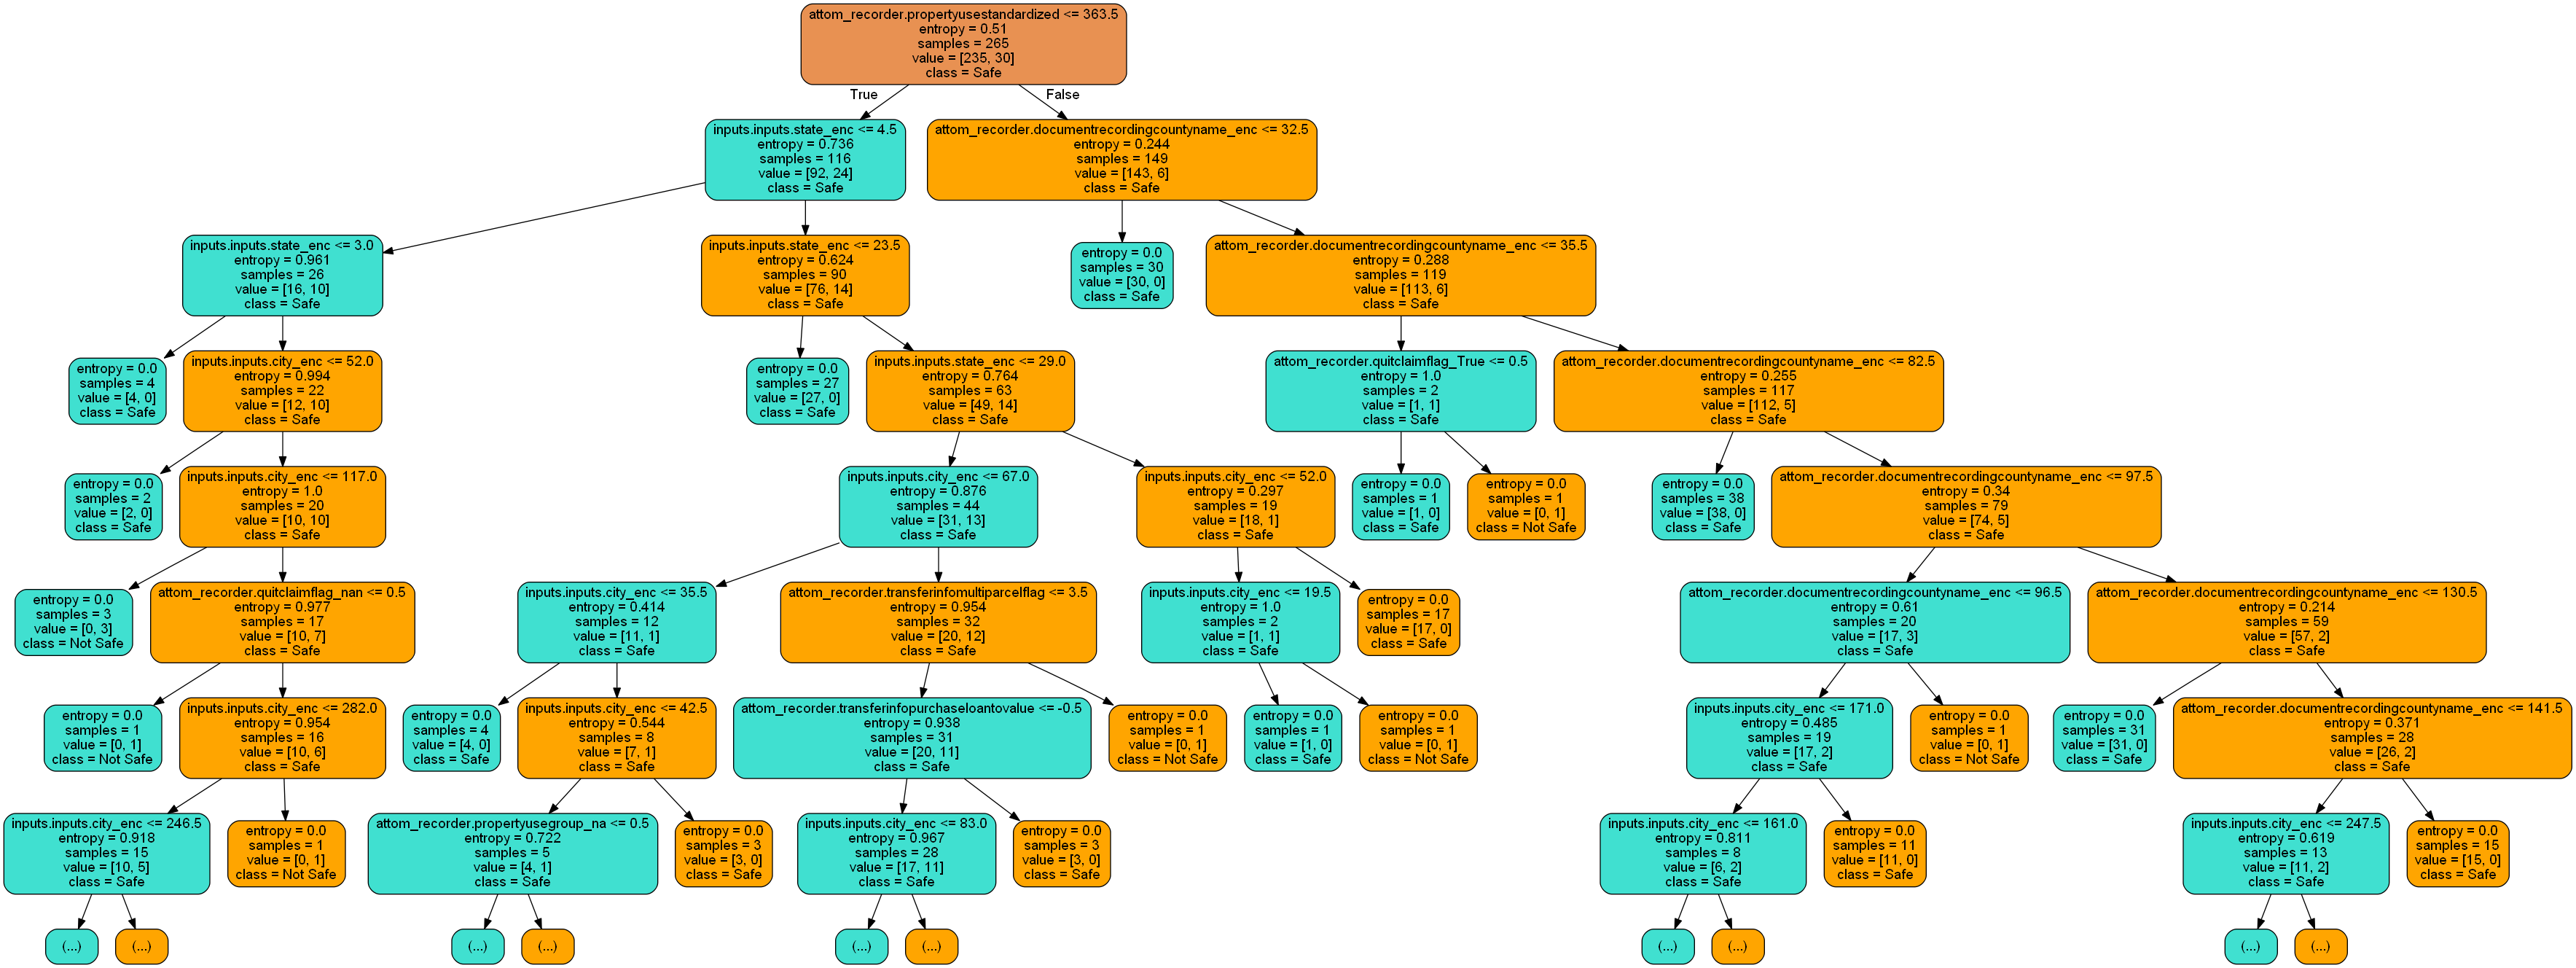

In [72]:
import graphviz 
import os
import pydotplus
import pydot
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

dot_data = tree.export_graphviz(clf, feature_names=feature_cols, class_names=['Safe','Not Safe'], max_depth = 7, filled=True, rounded=True, out_file=None) 

graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

#graph.render("safety", view=True) 
graph.write_png("safety.png")
Image(graph.create_png())


In [73]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5746527777777779

Next steps would be to tune the model with varying levels of parameters like max_tree_depth, min_samples_split, max_feature, etc to avoid overfitting. 

And get the rest of the 11k or so observations :)